# Scraped YahooNews Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import unicodedata

df = pd.read_csv("News.csv")
df = df[df.url.isna()==False]

In [2]:
df.head()

,title,authors,datetime,text,summary,keywords,url,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,Meghan McCain Admits She 'Underestimated' Pelo...,Amy Russo,1/28/2019 12:19,Meghan McCain on Sunday admitted she misjudged...,NaN,NaN,https://web.archive.org/web/20190128153622/htt...,NaN,NaN,NaN
1,Antigovernment protesters clash with police in...,Yahoo News Photo Staff,11/24/2018 23:09,Antigovernment protesters clashed with French ...,NaN,NaN,https://web.archive.org/web/20190125211036/htt...,NaN,NaN,NaN
2,77th anniversary of the Pearl Harbor attack,Yahoo News Photo Staff,12/7/2018 18:15,"On the morning of Dec. 7, 1941, a Sunday, Japa...",NaN,NaN,https://web.archive.org/web/20190131010817/htt...,NaN,NaN,NaN
3,Deadly shooting spree,NaN,1/7/2019 21:04,Family of five killed in head on crash as they...,NaN,NaN,https://web.archive.org/web/20190107233559/htt...,NaN,NaN,NaN
4,"No Sleeves, No Bible, No Problem: This Is How ...",Natalie Gontcharova,1/4/2019 20:26,It was quite a Moment when the anti-LGBTQ+ Mik...,NaN,NaN,https://web.archive.org/web/20190104231044/htt...,NaN,NaN,NaN


In [3]:
print(f"There are {len(df)-df.summary.isna().sum()} non-missing 'summary' rows"+
      f" and {len(df)-df.keywords.isna().sum()} non-missing 'keywords' rows")

There are 2 non-missing 'summary' rows and 2 non-missing 'keywords' rows


In [4]:
df[df.keywords.isna()==False]

,title,authors,datetime,text,summary,keywords,url,Unnamed: 7,Unnamed: 8,Unnamed: 9
3037,2) Any U.S. federal,state,or local domestic government discussing,offering,or providing,or being solicited to discuss,offer,or provide,any emolument on or after November 8,2016 to (a) Donald Trump or his Business Inte...
3045,1) Any personal or work diary,journal,or other book containing notes,a record or a description of daily events rel...,(b) the Trump Campaign,(c) the Executive Office of the President,or (d) the Trump Organization from June 2015 ...,NaN,NaN,NaN


In [5]:
df = df[df.keywords.isna()]

print(f"There are {len(df)-df.summary.isna().sum()} non-missing 'summary' rows"+
      f" and {len(df)-df.keywords.isna().sum()} non-missing 'keywords' rows")

There are 0 non-missing 'summary' rows and 0 non-missing 'keywords' rows


In [6]:
df = df.drop(['Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'keywords', 'summary'], axis=1)

In [7]:
import re

def process_text(s):
    r = re.compile(r'\W+')
    new_s = r.sub(' ', str(s).replace("''", "").replace(".",""))
    new_s = " ".join([_ for _ in new_s.split() if len(_)>1])
    if new_s!="nan": return new_s.lower()
    else: return ""

In [8]:
df.text = df.text.apply(process_text)
df.title = df.title.apply(process_text)

In [9]:
def process_url(url):
    date = re.search('http[s]://web.archive.org/web/(\d+)/http', str(url)).group(1)
    title = re.search('http[s]://news.yahoo.com/(.*?).html', str(url)).group(1)
    uid = title.split("-")[-1]
    title = " ".join(title.split("-")[:-1])
    return [date[:4], date[4:6], date[6:8], uid, title]

In [10]:
def test_func(x, func):
    try:
        func(x)
        return 1
    except:
        return 0

In [11]:
test = df.url.apply(lambda x: test_func(x, process_url))
print(f"There are {len(df) - test.sum()} rows with messed up URLs")

There are 0 rows with messed up URLs


In [12]:
processed_urls = df.url.apply(process_url)

In [13]:
processed_urls

0        [2019, 01, 28, 121909421, meghan mccain admits...
1        [2019, 01, 25, 230955951, antigovernment prote...
2        [2019, 01, 31, 151316903, 75th anniversary pea...
3        [2019, 01, 07, 210440329, video/deadly shootin...
4        [2019, 01, 04, 202600722, no sleeves no bible no]
                               ...                        
18535    [2018, 12, 11, 170925800, trumps losing lonely...
18536    [2018, 12, 11, 181505324, heated clash pelosi ...
18537    [2018, 12, 11, 215339449, see trump not replac...
18538    [2018, 12, 11, 213144687, wisconsin gops power...
18539    [2018, 12, 11, 151316903, 75th anniversary pea...
Name: url, Length: 18509, dtype: object

In [14]:
df = pd.concat([df, pd.DataFrame(processed_urls.values.tolist(), 
                                 columns=['url_year', 'url_month', 'url_day', 'url_id', 'url_title'], 
                                 index=processed_urls.index)], axis=1)

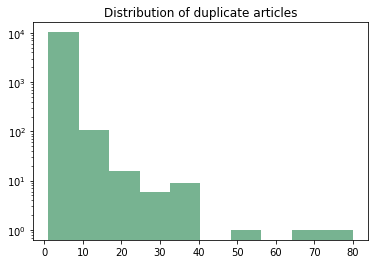

In [15]:
plt.hist(df.url_id.value_counts(), color="seagreen", alpha=0.65)
plt.yscale('log')
plt.title('Distribution of duplicate articles');

In [16]:
repeats=df.url_id.value_counts()
print(repeats)

201900455     80
politics      68
topstories    55
230955951     40
151316903     40
              ..
183843445      1
172810153      1
165951309      1
153244835      1
200929791      1
Name: url_id, Length: 10405, dtype: int64


In [17]:
def isnt_int(n):
    try:
        int(n)
        return 0
    except:
        return 1

print(f"There are {sum([isnt_int(_) for _ in repeats.index])} improperly extracted url ids")

There are 29 improperly extracted url ids


In [18]:
df.url_title[df.url_id=="topstories"].head()

60      5 people dead louisiana shooting suspect large...
203     teen commits suicide accidentally shooting kil...
1170    minnesota mom charged car seat falls child 214...
2046    more 9 000 marijuana convictions dismissed lat...
2204    4 old boy accidentally shoots pregnant mom bab...
Name: url_title, dtype: object

In [19]:
correct_extracts = [_ for _ in repeats.index if isnt_int(_)==0]

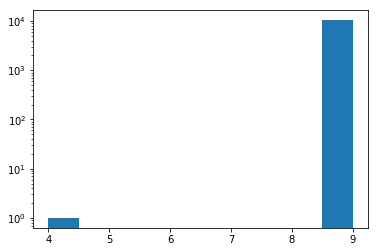

In [20]:
plt.hist([len(_) for _ in correct_extracts])
plt.yscale('log');

In [21]:
[_ for _ in correct_extracts if len(_)<9]

['2019']

In [22]:
df = df[df.url_id!="2019"]

In [23]:
def fix_urls(url):
    section = re.search('http[s]://news.yahoo.com/(.*?).html', str(url)).group(1)
    try:
        url_id = re.search('(\d{9})', section).group(1)
    except:
        url_id = ""
    url_title = " ".join([_ for _ in section.split("-") if _!=url_id])
    return [url_id, url_title]

In [24]:
test = df.url.apply(lambda x: test_func(x, fix_urls))
print(f"There are {len(df) - test.sum()} rows with messed up URLs")

There are 0 rows with messed up URLs


In [25]:
df[['url_id', 'url_title']] = df.url.apply(fix_urls).values.tolist()

In [26]:
repeats = df.url_id.value_counts()
print(repeats)

201900455    80
051052692    40
151316903    40
230955951    40
010052703    40
             ..
174418112     1
150651721     1
135322663     1
042117261     1
000321114     1
Name: url_id, Length: 10522, dtype: int64


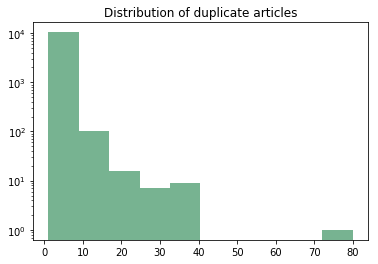

In [27]:
plt.hist(df.url_id.value_counts(), color="seagreen", alpha=0.65)
plt.yscale('log')
plt.title('Distribution of duplicate articles');

In [28]:
print(f"There are/is {sum([isnt_int(_) for _ in repeats.index])} improperly extracted url id(s)")

There are/is 1 improperly extracted url id(s)


In [29]:
# This 1 improper url_id actually represents 32 rows of data but I'm just going to drop them all

df = df[df.url_id!=""]

In [30]:
df = df.drop_duplicates(subset="url_id", keep='first')

In [31]:
def split_dt(d):
    try:
        d = d.split(" ")[0].split("/")
        return [d[2], d[0], d[1]]
    except:
        return ["", "", ""]

new_dt = df['datetime'].apply(split_dt)

In [32]:
test = df['datetime'].apply(lambda x: test_func(x, split_dt))

In [33]:
df = pd.concat([df, pd.DataFrame(new_dt.values.tolist(), columns=['article_year', 'article_month', 'article_day'], 
                                 index=new_dt.index)], axis=1)

In [38]:
m_titles = len(df[df.title==""])
m_articles = len(df[df.text==""])
m_both = len(df[df.title==''][df.text==''])
print(f"There are {m_titles} rows with missing titles and {m_articles} rows with missing articles")
print(f"There are {m_both} rows missing both titles and articles")

There are 429 rows with missing titles and 428 rows with missing articles
There are 428 rows missing both titles and articles


C:\Users\steph\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [42]:
df = df[df.title!=''][df.text!='']
df = df.drop(['url_id'], axis=1)

In [43]:
print(f"The cleaned data has {len(df)} rows of data")

The cleaned data has 10092 rows of data


In [44]:
df.to_csv("C:/Data/Bernie/CleanedNews.csv", index=False)